#Initialization

In [ ]:
#Importing Drive
import sys
runningOnColab = 'google.colab' in sys.modules
if runningOnColab:
  from google.colab import drive
  drive.mount('/content/drive')
  %cd '/content/drive/Shareddrives/ECE232E/Project 4'

Mounted at /content/drive
/content/drive/Shareddrives/ECE232E/Project 4


In [ ]:
!pip3 install numpy
import numpy as np
import pandas as pd
!pip install igraph
import igraph as ig
import json
import csv
import matplotlib.pyplot as plt 
# !pip install cairocffi
# import cairocffi
# !apt install libcairo2-dev
# !pip install pycairo
# import cairo
import networkx as nx
from scipy.spatial import Delaunay

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.1 MB 5.0 MB/s 


In [ ]:
import csv
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import igraph as ig
from scipy.spatial import Delaunay
from igraph import *
import random

#File uploading

In [ ]:
graph_data = pd.read_csv('los_angeles-censustracts-2019-4-All-MonthlyAggregate.csv')
graph_data = graph_data.drop(['standard_deviation_travel_time', 'geometric_mean_travel_time', 'geometric_standard_deviation_travel_time'], axis=1)
graph_data = graph_data.drop(graph_data[graph_data.month != 12].index)
dec_data_only = graph_data.drop(['month'], axis=1)
dec_data = np.asarray(dec_data_only) 

paths = {}
positions = np.unique(np.concatenate([dec_data[:,0],dec_data[:,1]]))
counter = 0

for row in dec_data:
    position = tuple(np.sort(row[0:2]))
    if position in paths:
        paths[position].append(row[2])
        counter += 1
    else:
        paths[position] = [row[2]]
        
with open('december_only.txt','w') as f:
    for positions in paths:
        string = '{} {} {:.2f}\n'.format(int(positions[0]),int(positions[1]),np.mean(paths[positions]))
        f.write(string)

#Question 9:

Report the number of nodes and edges in G

In [ ]:
G = ig.Graph.Read(f = 'december_only.txt', format = 'ncol', directed = False)

GCC = G.components().giant()
#ig.summary(GCC)

print("The number of nodes: ",len(GCC.vs))
print("The number of edges: ",len(GCC.es))

The number of nodes:  2649
The number of edges:  1003858


#Question 10:
Build a minimum spanning tree (MST) of graph G. Report the street addresses near the two endpoints (the centroid locations) of a few edges. Are the results intuitive?

In [ ]:
with open('los_angeles_censustracts.json') as json_data:
  geographic_data = json.load(json_data)

geographic_data = geographic_data['features']

dict_1 = {}

for info in geographic_data:
    entry_pt = {}
    coordinates = info['geometry']['coordinates'][0][0]
    if len(coordinates) > 2:
      mean_coord = np.mean(np.asarray(coordinates),axis=0)
    else:
      mean_coord = coordinates
    movement_id = info['properties']['MOVEMENT_ID']
    entry_pt['coord'] = coordinates
    entry_pt['mean_coord'] = mean_coord
    entry_pt['display_name'] = info['properties']['DISPLAY_NAME']
    dict_1[movement_id] = entry_pt

#sample_entry in this dict
print(dict_1['1'])

{'coord': [-118.11683, 34.107225], 'mean_coord': [-118.11683, 34.107225], 'display_name': 'Census Tract 480302'}


In [ ]:
mst = GCC.spanning_tree(weights = GCC.es["weight"])
vertices = mst.vs()
#ig.summary(mst)

print("The number of nodes: ",len(mst.vs))
print("The number of edges: ",len(mst.es))

The number of nodes:  2649
The number of edges:  2648


In [ ]:
count = 1
print("Coordinates/street addresses near the two endpoints (the centroid locations) of a few edges:")
for e in mst.es():
    st = e.tuple
    print(dict_1[vertices[st[0]]['name']]['display_name'],'---',dict_1[vertices[st[1]]['name']]['display_name'])
    if count == 10:
      break
    count += 1

# https://data.lacounty.gov/widgets/rv2f-zsc7
# https://geohub.lacity.org/datasets/enriched-la-county-census-tracts-2015/
# 554001 -- 554002 Bellflower city
# 461700 -- 460800 Pasadena city
# 302201 -- 302202 Glendale city
# 407101 -- 407002 La Puente city
# 433401 -- 433402 El Monte city
# 543603 -- 294410 Carson city -- Los Angeles city
# 482001 -- 530700 Monterey Park city
# 460800 -- 463800 Pasadena city
# 269100 -- 217001 Los Angeles city
# 011000 -- 001901 ??? 

Coordinates/street addresses near the two endpoints (the centroid locations) of a few edges:
Census Tract 554001 --- Census Tract 554002
Census Tract 461700 --- Census Tract 460800
Census Tract 302201 --- Census Tract 302202
Census Tract 407101 --- Census Tract 407002
Census Tract 433401 --- Census Tract 433402
Census Tract 543603 --- Census Tract 294410
Census Tract 482001 --- Census Tract 530700
Census Tract 460800 --- Census Tract 463800
Census Tract 269100 --- Census Tract 217001
Census Tract 011000 --- Census Tract 001901


#Question 11:

Determine what percentage of triangles in the graph (sets of 3 points on the map) satisfy the triangle inequality. You do not need to inspect all triangles, you can just estimate by random sampling of 1000 triangles.

In [ ]:
total_triangle = 1000
idx_max = len(GCC.vs()) - 1  
edge_seq = EdgeSeq(GCC)
used_id = set()
satisfied = 0
count = 0

def check_if_triangle():
    current_id = ()
    indices = []
    weights = []
    for i in range(0,3):
        indices.append(random.randint(0,idx_max))        
    current_id = tuple(sorted(indices))
    while(current_id in used_id):
        for i in range(0,3):
            indices.append(random.randint(0,idx_max))        
        current_id = tuple(sorted(indices))  
    for i in current_id:
        weights.append(edge_seq[i]["weight"])
    if weights[0] < weights[1] + weights[2] and weights[1] < weights[0] + weights[2] and weights[2] < weights[0] + weights[1]:
        return True, current_id
    else:
        return False, current_id

while count < total_triangle:              
    for i in range(0,3):
        satisfy, current_set = check_if_triangle()
        if satisfy:
            break                  
    used_id.add(current_set)
    if satisfy:
        satisfied += 1
    count += 1  
 
print('The percentage of triangles in the graph that satisfy the triangle inequality:', str((satisfied/total_triangle)*100)   )

The percentage of triangles in the graph that satisfy the triangle inequality: 91.7


#Question 12:

Find an upper bound on the empirical performance of the approximate algorithm

In [ ]:
def a_walk(mst, walk, visited, vset):
    current = walk[-1]
    if len(walk) > 1 and current == walk[0]: 
      return True
    else:
        edges = mst.es.select(_between = ([current],vset))
        for edge in edges:
            if not edge in visited:
                visited.add(edge)
                node_tuple = edge.tuple
                if node_tuple[0] == current:
                    next_node = node_tuple[1]
                else:
                    next_node = node_tuple[0]
                walk.append(next_node)
                next_walk = a_walk(mst, walk, visited, vset)
                if next_walk:
                    return True
                else:
                    walk.pop()
                    visited.remove(edge)       
        return False
            
def euler_dist(mst, v, vset):
    edges = mst.es.select(_source_in = [v])
    if len(edges) == 0: 
      return [v] 
    else:
        walk = [v]
        visited = set()
        a_walk(mst, walk, visited, vset)
        for i in range(len(walk) - 1):
            walk_edges = mst.es.select(_between = ([walk[i]], [walk[i+1]]))
            mst.delete_edges(walk_edges[0])
        results = []
        for node in walk:
            next_walk = euler_dist(mst, node, vset)
            for e in next_walk:
                results.append(e)   
        return results
            
def approx_algorithm(g):
    my_mst = g.spanning_tree(weights = GCC.es["weight"])
    mst_edges = my_mst.es()
    edge_list = []
    for edge in mst_edges:
      edge_list.append(edge.tuple)
    mst_temp = mst.as_undirected()
    mst_temp.add_edges(edge_list)
    mst_double = mst_temp.as_undirected()
    e_walk = euler_dist(mst_double, 0, mst_double.vs())
    path = []
    visited = set()
    for i in e_walk:
      if not i in visited:
          path.append(i)
          visited.add(i)  
    total_weight = 0
    final_path = []
    for i in range(len(path) - 1):
      i_1 = path[i]
      i_2 = path[i + 1]
      edges = g.es.select(_between = ([i_1], [i_2]))
      if len(edges) > 0:
          total_weight += edges[0]['weight']
          final_path.append(i_1)
      else:
          total_weight += GCC.shortest_paths([i_1], [i_2], weights = GCC.es()['weight'])[0][0]
    return mst, total_weight, final_path

In [ ]:
import sys

sys.setrecursionlimit(10000)
my_mst, total_weight, final_path = approx_algorithm(GCC)

print('The MST cost:',sum(mst.es['weight']))
print('The Approximate cost:',total_weight)
print('The upper bound on the empirical performance of the approximate algorithm:', total_weight / sum(mst.es['weight']))

The MST cost: 269084.6100000002
The Approximate cost: 465542.44000000047
The upper bound on the empirical performance of the approximate algorithm: 1.579951107931527


#Question 13:

Plot the trajectory that Santa has to travel!

In [ ]:
lat = []
lon = []

for i in final_path:
    lat.append(dict_1[my_mst.vs[i]['name']]['mean_coord'][1])
    lon.append(dict_1[my_mst.vs[i]['name']]['mean_coord'][0])

plot_lati = np.hstack(lat)
plot_longi = np.hstack(lon)

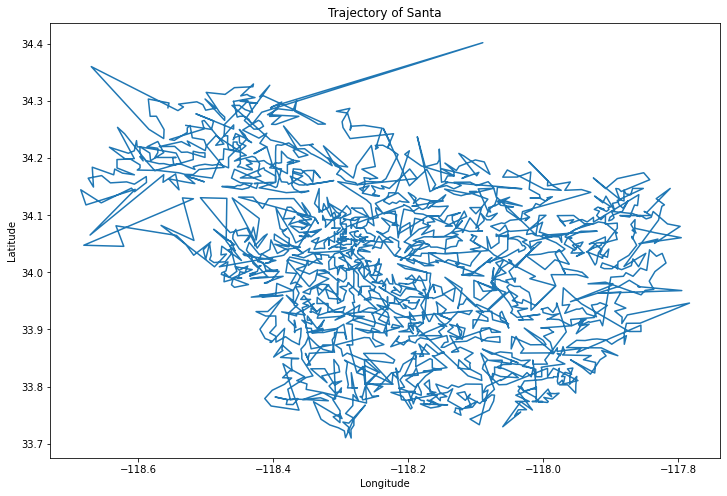

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(plot_longi, plot_lati)
plt.title('Trajectory of Santa')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [ ]:
BBox = ((-118.75,   -117.75,      
         33.7, 34.4))

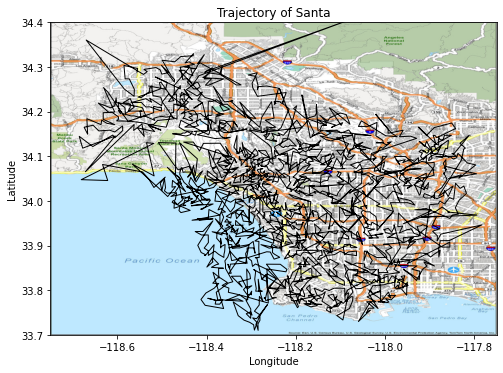

In [ ]:
map_LA = plt.imread('map_LA.jpeg')
fig, ax = plt.subplots(figsize = (8,7))
ax.plot(plot_longi, plot_lati, color = "black", linewidth = 1)
ax.set_title('Trajectory of Santa')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(map_LA, zorder = 0, extent = BBox, aspect = 'equal')
plt.show()

In [ ]:
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))

tot_dist = 0

for i in range(len(plot_lati)-1):
  lati1 = plot_lati[i]
  lati2 = plot_lati[i+1]
  longi1 = plot_longi[i]
  longi2 = plot_longi[i+1]
  temp = haversine(lati1,longi1,lati2,longi2)
  tot_dist = tot_dist + temp

tot_dist = round(tot_dist,3)
print("The total distance in km:",tot_dist)

The total distance in km: 4364.616


In [ ]:
santa_speed = 4364.616/6.0
santa_speed = round(santa_speed,3)

print("Speed of Santa in km/hr:", santa_speed)

Speed of Santa in km/hr: 727.436


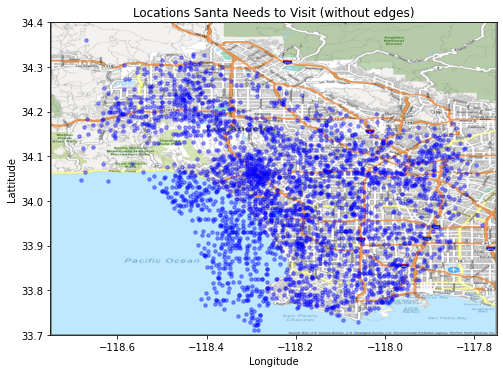

In [ ]:
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(plot_longi, plot_lati, zorder = 1, alpha = 0.4, c = 'b', s = 12)
ax.set_title('Locations Santa Needs to Visit (without edges)')
plt.xlabel('Longitude')
plt.ylabel('Lattitude')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(map_LA, zorder = 0, extent = BBox, aspect = 'equal')
plt.show()

#Question 24:

Brainstorm with your group, then define and implement a new interesting task based on the dataset at hand. We recommend you to download and use data of other time periods. The duration of this data should be at least three months. For example you may use January 2020 to March 2020 in which the major changes happened to daily’s commutes.

In [ ]:
import json
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt 


optimal_cost = {'djibouti':6656,'egypt':172387,'oman':86891,'tanzania':394718,'canada':1290319}
# optimal_cost = {'djibouti':38,'egypt':7146,'oman':1979,'tanzania':6117,'canada':4663}
# increasing order of cities - djibouti (38), oman (1979), canada (4663), tanzania (6117), egypt (7146)
country = 'oman'
data = pd.read_csv(country+'.txt',delimiter=' ',index_col=0,header=None,names=['a','b'])


n = len(data)
cost_matrix = np.zeros((n,n))
a, b = data['a'].values, data['b'].values
for i in range(n):
	x1, y1 = a[i], b[i]
	for j in range(n):
		x2, y2 = a[j], b[j]
		cost_matrix[i,j] = np.sqrt((x1-x2)**2 + (y1-y2)**2)
		if i == j: 
			cost_matrix[i,j] = np.inf

In [ ]:
#print(cost_matrix)
print(len(cost_matrix))

In [ ]:
g = nx.from_numpy_array(cost_matrix)
gcc = g.subgraph(max(nx.connected_components(g), key=len))
mst = nx.minimum_spanning_tree(gcc)
multigraph = nx.MultiGraph()
mst_cost = 0

for i in mst.edges:
	w = mst.edges[i[0],i[1]]['weight']
	mst_cost += w
	multigraph.add_edge(i[0],i[1],weight=w)
	multigraph.add_edge(i[0],i[1],weight=w)

print("Start finding cycle")
tour = [u for u,v in nx.eulerian_circuit(multigraph)]
emb_tour, visited = [], set()
for i in tour:
	if i not in visited: 
		emb_tour.append(i)
		visited.add(i) 
emb_tour.append(emb_tour[0])
print("Finish cycle")

In [ ]:
multigraph_cost = 0
for i in range(len(emb_tour)-1):
	s,t = emb_tour[i], emb_tour[i+1]
	w = 0
	if mst.has_edge(s,t): w = mst.edges[s,t]['weight']
	else: w = cost_matrix[s,t]
	multigraph_cost += w
print(multigraph_cost)
print('rho = ',multigraph_cost/optimal_cost[country])

In [ ]:
ratios = [1.3189172043127988,1.3702510997279176,1.389543336852672,1.3815820939776107,1.3521031284681255]
dj, eg, om, tanz, can = (6656*ratios[0]-6656)*100/6656, (172387*ratios[1]-172387)*100/172387, (86891*ratios[2]-86891)*100/86891, (394718*ratios[3]-394718)*100/394718, (1290139*ratios[4]-1290139)*100/1290139
num_city = [38,1979,4663,6117,7146]
print("Djibouti:",dj,", Egypt:", eg,", Oman:", om,", Tanzania:", tanz,", Canada:", can)
plt.plot(num_city,ratios)